In [72]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Ejemplo 1

Dada una señal de entrada y salida (archivo class_09.csv), obtenga el modelo estimado usando el modelo ARMAX.

**Paso 1: Lectura de los datos**

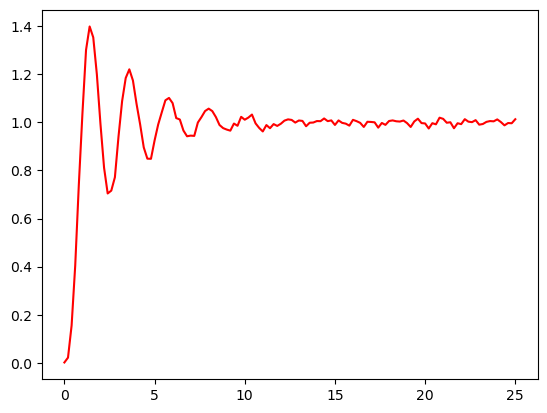

In [73]:
datos = pd.read_csv ('data\clase_09.csv')
t = datos.t
yn = datos.yn
N = len(t)
u = datos.un
plt.plot(t,yn,color = 'red')
dt = (t[1] - t[0])

## Definiendo la matriz de regresión

**Paso 2:** Proponer el regresor de la estimación ARX y calcular los parámetros $\theta$ de la estimación ARX, para este ejemplo se propone:

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1],u[k-2],u[k-3]]$$

In [74]:
## Definir y_1, y_2, dependiendo el sistema que se quiera modelar, 
## así como u_1, u_2 y las que se requieran

y_1 = np.zeros(N)
y_2 = np.zeros(N)
y_3 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
u_3 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
for k in range(3,N):
    y_3[k]=yn[k-3]
    u_3[k]=u[k-3]

## Creación del vector phi
phi = np.array([-y_1,-y_2,-y_3,u_1,u_2,u_3]).transpose()

## Definición de matriz de pesos para dar mayor peso al transitorio
pesos = np.zeros(N)
for k in range(0,N):
    #pesos[k]=10*np.exp(-k)
    pesos[k]=10
W = np.eye(N)*pesos.transpose()

_phi = np.dot(W,phi)
_yn = np.dot(W,yn)

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 0
A = np.dot(_phi.T,_phi) + alpha*np.eye(len(np.dot(_phi.T,_phi)))
theta = np.dot(np.linalg.inv(A),np.dot(_phi.T,_yn))
theta

array([-1.22294604,  0.29244777,  0.24055746,  0.01990261,  0.1092933 ,
        0.17904276])

In [75]:
dfReg = pd.DataFrame(data={'y':yn,'y_1':y_1,'y_2':y_2,'y_3':y_3,'u_1':u_1,'u_2':u_2,'u_3':u_3})
#sns.pairplot(dfReg)

In [76]:
#sns.distplot(dfReg)

## Armando la función estimada ARX

**Paso 3:** Definir la función de transferencia estimada $G_e$

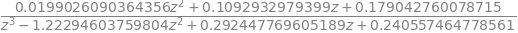

In [77]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2 + theta[2]*z**-3 
B =  theta[3]*z**-1 +theta[4]*z**-2+theta[5]*z**-3  

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()
G

## Calculando la respuesta al step de la estimación

**Paso 4:** Calculamos la respuesta de la función $G_e$ y con esos datos determinamos el error de la estimación inicial.

In [78]:
## Función de transferencia
G_e = control.tf([theta[3],theta[4],theta[5]],[1,theta[0],theta[1],theta[2]],dt)
G_e

TransferFunction(array([0.01990261, 0.1092933 , 0.17904276]), array([ 1.        , -1.22294604,  0.29244777,  0.24055746]), 0.2)


   0.0199 z^2 + 0.1093 z + 0.179
-----------------------------------
z^3 - 1.223 z^2 + 0.2924 z + 0.2406

dt = 0.2



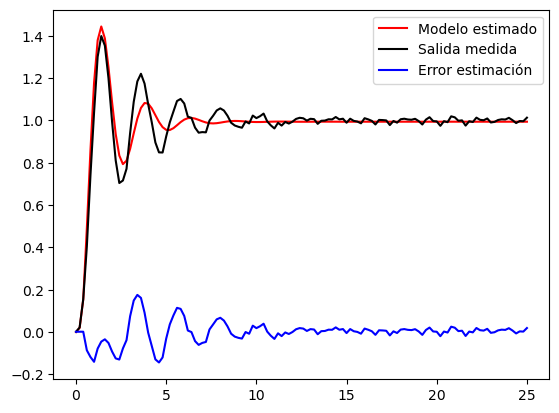

In [79]:
## Definiendo la función de transferencia estimada ARX
_,ye = control.step_response(G_e,t)

## Ganancia de ajuste
k = 1;
ye = k*ye

## Señal de error estimado
e = yn-ye

plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.plot(t,e,color = 'blue')
plt.legend(['Modelo estimado','Salida medida','Error estimación'])

print(G_e)

## Planteando el nuevo regresor

**Paso 5:** Se va propone un nuevo regresor que incluya la señal de error estimada en el paso anterior

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1],u[k-2],u[k-3],e[k-1],e[k-2],e[k-3]]$$

In [80]:
e_1 = np.zeros(N)
e_2 = np.zeros(N)
e_3 = np.zeros(N)

for k in range(1,N):
    e_1[k]=e[k-1]
for k in range(2,N):
    e_2[k]=e[k-2]
for k in range(3,N):
    e_3[k]=e[k-3]
## Creación del vector phi
phi2 = np.array([-y_1,-y_2,-y_3,u_1,u_2,u_3,e_1,e_2,e_3]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

Am = np.dot(phi2.T,phi2) + alpha*np.eye(len(np.dot(phi2.T,phi2)))
theta2 = np.dot(np.linalg.inv(Am),np.dot(phi2.T,yn))
theta2

array([-2.05510969,  1.62627541, -0.43234035,  0.02003303,  0.09250809,
        0.02600525, -0.92896903,  1.52091078, -0.84108486])

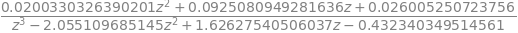

In [81]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A

## Construir los polinomios A(z) y B(z)
A = 1 + theta2[0]*z**-1 + theta2[1]*z**-2+ theta2[2]*z**-3  
B = theta2[3]*z**-1+theta2[4]*z**-2+theta2[5]*z**-3 
C = 1 + theta2[6]*z**-1 + theta2[7]*z**-2 + theta2[8]*z**-3 
G = (B/A).simplify()
G

TransferFunction(array([0.02003303, 0.09250809, 0.02600525]), array([ 1.        , -2.05510969,  1.62627541, -0.43234035]), 0.2)

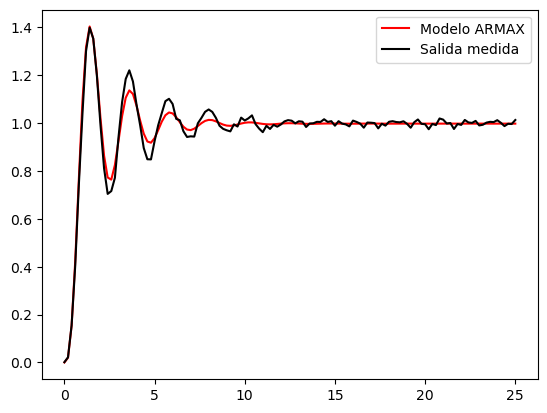

In [82]:
## Armando la función de transferencia estimada con los parámetros hallados
G2 = control.tf([theta2[3],theta2[4],theta2[5]],[1,theta2[0],theta2[1],theta2[2]],dt)

## Se determina la respuesta estimada al escalón
_,y2 = control.step_response(G2,t)

e2 = yn-y2

plt.plot(t,y2,color = 'red')
plt.plot(t,yn,color = 'black')
#plt.plot(t,e2,color = 'green')

plt.legend(['Modelo ARMAX','Salida medida']);
G2

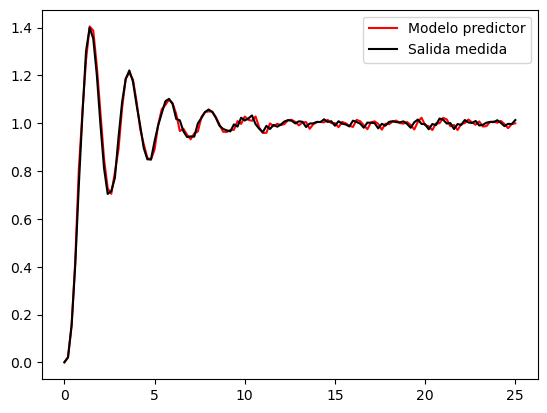

In [83]:
## Armando la función estimada con los parámetros hallados y usando 
## la fórmula del predictor.

yf = (-theta2[0]*y_1 - theta2[1]*y_2 - theta2[2]*y_3 + 
      theta2[3]*u_1 + theta2[4]*u_2 + theta2[5]*u_3 + 
      (theta2[6]*e_1+theta2[7]*e_2+theta2[8]*e_3)  )
plt.plot(t,yf,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo predictor','Salida medida'])

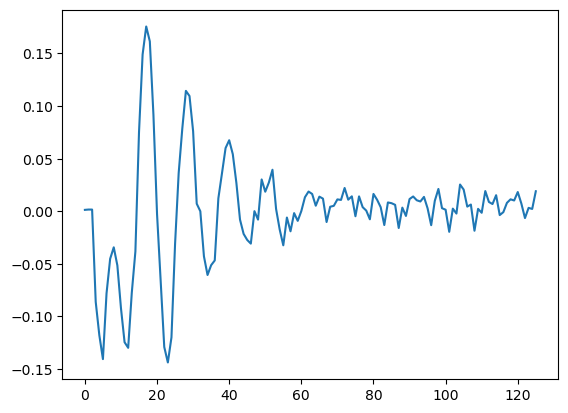

In [84]:
plt.plot(e)